# Goal
* I want to experiment with solving NMF with Generalized KL divergence (one type of beta divergence) by combining low rank approximation and multiplicative update. 

# Procedure
* I use a small simulated data $X$ generated from poisson distribution (code shown in the very end).

* First, I directly apply `nnmf` with `loss = 'mkl', method = 'mu'` and run for 200 iterations.

* Then: I get various $\hat{X}$ using different low-rank approximation; apply `nnmf` to $\hat{X}$ with `loss = 'mkl', method = 'mu'` and run for 200 iterations.

* Finally I compare cost (generalized kl divergence without some constant, shown in the end).

# Result:
* It seems promising: we can beat `nnmf` on `X` in cost. 
* It is a bit surprising that we get better result when using $d = k$ (probably because of some random luck?)
* Note that this is a very very simple and small dataset, very different from GTEx dataset I used (for example no extremely large counts). 

Below I show my experiments

In [1]:
library(rsvd)
library(NNLM)
source("../code/data_generation.R")
source("../code/misc.R")
set.seed(123)

## generate data

In [2]:
n = 500
p = 1000
k = 5
out = topic_poisson_generator(n,p,k)
X = out$X
cat(sprintf("dim(X) = (%d %d)\n", dim(X)[1], dim(X)[2]))
A0 = out$A
W0 = out$W
Lam0 = A0 %*% W0
cost0 = cost(X,Lam0, e = 0)
cat(sprintf("(beta divergence) cost of oracle is: %f\n", cost0))

dim(X) = (1000 500)
(beta divergence) cost of oracle is: -12916099.749512


In [3]:
A_init = matrix(runif(p*k, 0, 1), nrow = p)
W_init = matrix(runif(n*k, 0, 1), nrow = k)

# nnmf with multiplicative update

In [4]:
start = proc.time()
out_nnmf = nnmf(X,init = list(W = A_init,H = W_init), k,loss = "mkl",method = "lee",max.iter = 200, rel.tol = 1e-20)
runtime = proc.time() - start
cat(sprintf("runtime: %f\n", runtime[[3]]))
cost_nnmf = cost(X, out_nnmf$W %*% out_nnmf$H, e = 0)
cat(sprintf("(beta divergence) cost of nnmf is: %f\n", cost_nnmf))

Warning message in system.time(out <- .Call("NNLM_nnmf", A, as.integer(k), init.mask$Wi, :
“Target tolerance not reached. Try a larger max.iter.”

runtime: 3.113000
(beta divergence) cost of nnmf is: -12919575.653897


## Comment:
NNMF is worse than oracle. (the smaller the cost, the better)

In [6]:
ds = c(3,5,10,20,50,100)
time_rsvd = c()
time_nnmf = c()
costs_rsvd = c()
for(d in ds){
    ## rsvd with d
    start = proc.time()
    out_rsvd = rsvd(X, d)
    runtime = proc.time() - start
    time_rsvd <- c(time_rsvd, runtime[[3]])
    
    Xhat = out_rsvd$u %*% diag(out_rsvd$d) %*% t(out_rsvd$v)
    Xhat[Xhat < 0] = 0
    
    ## nnmf with k
    start = proc.time()
    out_nnmf_xhat = nnmf(Xhat, k,init = list(W = A_init,H = W_init),
                         loss = "mkl",method = "lee",max.iter = 200, rel.tol = 1e-20)
    runtime = proc.time() - start
    time_nnmf <- c(time_nnmf, runtime[[3]])
    mycost = cost(X, out_nnmf_xhat$W %*% out_nnmf_xhat$H, e = 0)
    costs_rsvd = c(costs_rsvd, mycost)
}

Warning message in system.time(out <- .Call("NNLM_nnmf", A, as.integer(k), init.mask$Wi, :
“Target tolerance not reached. Try a larger max.iter.”Warning message in system.time(out <- .Call("NNLM_nnmf", A, as.integer(k), init.mask$Wi, :
“Target tolerance not reached. Try a larger max.iter.”Warning message in system.time(out <- .Call("NNLM_nnmf", A, as.integer(k), init.mask$Wi, :
“Target tolerance not reached. Try a larger max.iter.”Warning message in system.time(out <- .Call("NNLM_nnmf", A, as.integer(k), init.mask$Wi, :
“Target tolerance not reached. Try a larger max.iter.”Warning message in system.time(out <- .Call("NNLM_nnmf", A, as.integer(k), init.mask$Wi, :
“Target tolerance not reached. Try a larger max.iter.”Warning message in system.time(out <- .Call("NNLM_nnmf", A, as.integer(k), init.mask$Wi, :
“Target tolerance not reached. Try a larger max.iter.”

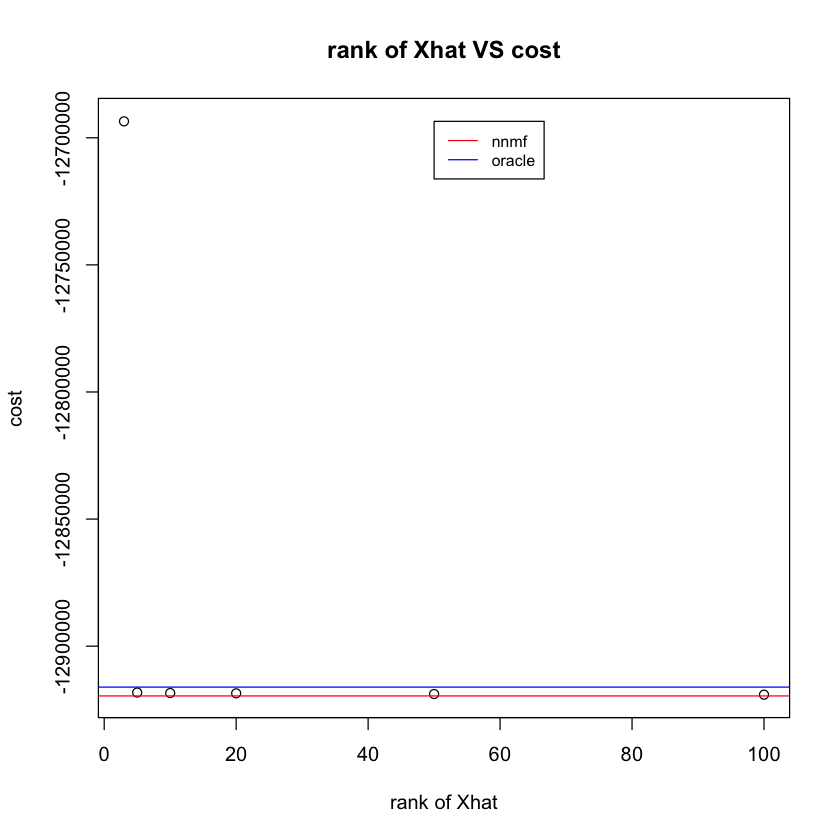

In [7]:
plot(ds, costs_rsvd, xlab = "rank of Xhat", ylab = "cost", main = "rank of Xhat VS cost")
abline(h = cost_nnmf, col = "red")
abline(h = cost0, col = "blue")
legend(x = ds[length(ds)-1], max(costs_rsvd), legend = c("nnmf", "oracle"), col = c("red", "blue"), lty=1:1, cex=0.8)

## Comment:
It seems we can get better result applying NMF_KL to approximated data!

In [ ]:
#plot(ds, time_nnmf, xlab = "rank of Xhat", ylab = "time in nnmf", main = "rank of Xhat VS time in nnmf")
#abline(h = 3.112000, col = "red")

# Compare Xhat & X

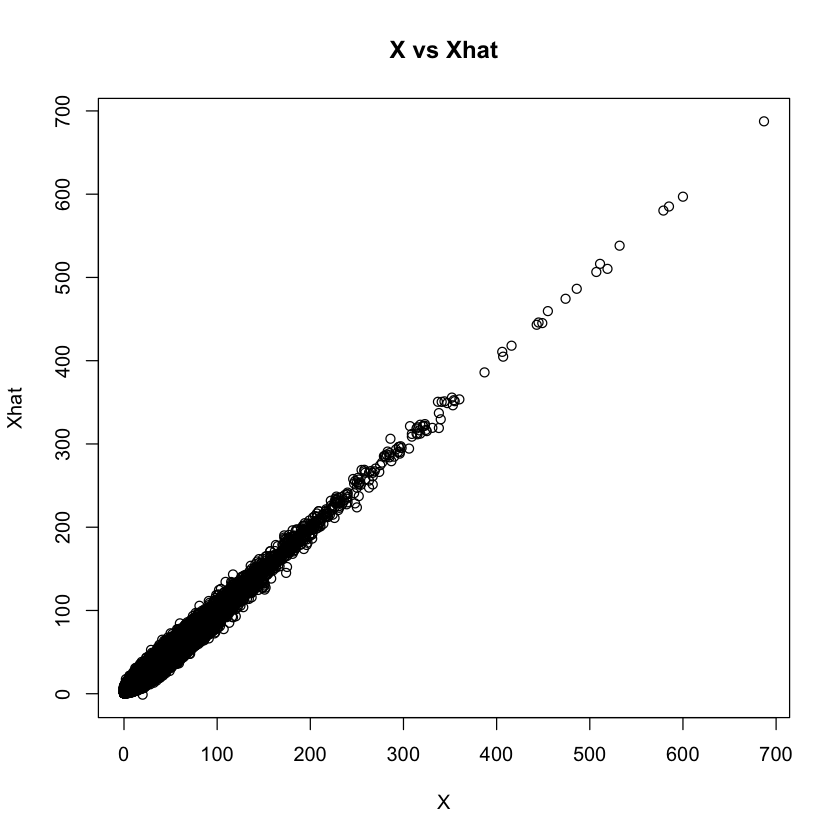

In [8]:
d = 20
out_rsvd = rsvd(X, d)
Xhat = out_rsvd$u %*% diag(out_rsvd$d) %*% t(out_rsvd$v)
#Xhat[Xhat < 0] = 0
plot(X,Xhat, main = "X vs Xhat")

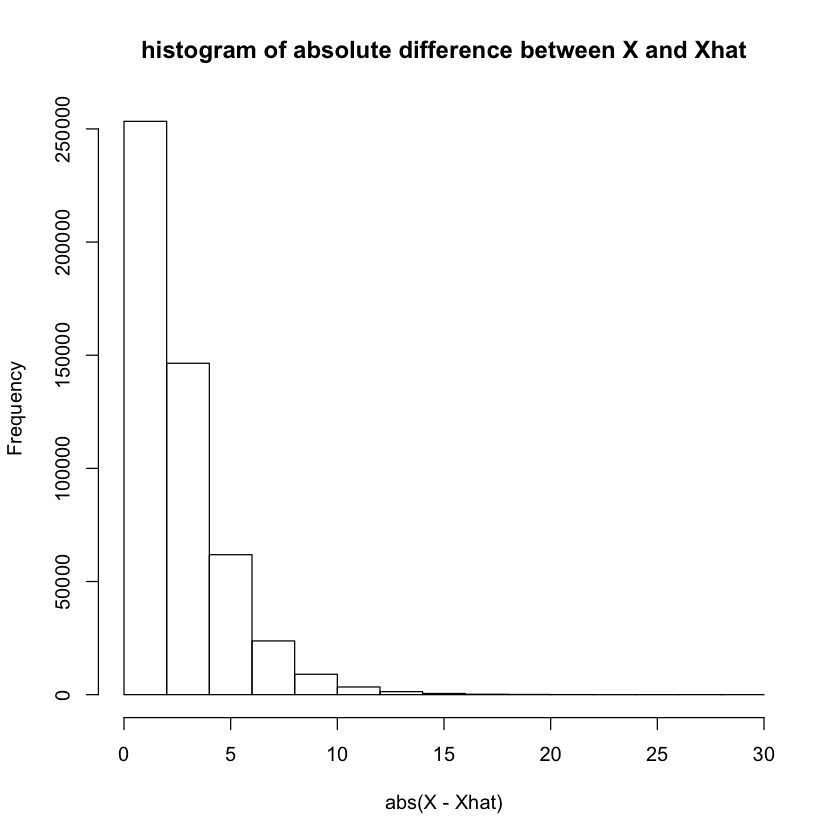

In [9]:
hist(abs(X-Xhat), main = "histogram of absolute difference between X and Xhat")

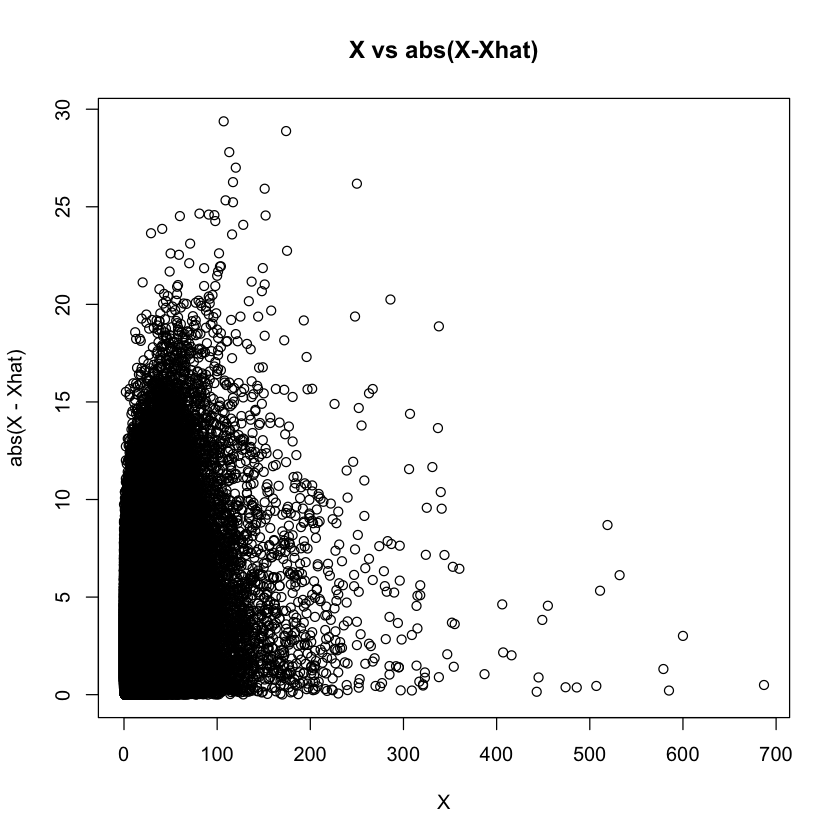

In [10]:
plot(X, abs(X - Xhat), main = "X vs abs(X-Xhat)")

## Comment:
It is a bit surprising that for very large counts, the mean difference is actually not too big. 

## Code for generating data & cost
```r
topic_poisson_generator <- function(n,p,k, seed = 0){
	## generate data X of size (p,n) with k hidden topics
	set.seed(seed)
	A = matrix(rnorm(p*k, 0, 1), nrow = p)
	A = exp(A)
	W = matrix(rnorm(k*n, 0, 1), nrow = k)
	W = exp(W)
	Lam = A %*% W
	X = matrix(rpois(n = p*n,lam = Lam), nrow = p)
	return(list(X = X, A = A, W = W))
}

cost <- function(X,AB, e){
	return(sum(AB - X * log(AB + e)))
}
```